## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [3]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt

--2024-02-07 21:38:43--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Risoluzione di www.dropbox.com (www.dropbox.com)... 2620:100:6025:18::a27d:4512, 162.125.69.18
Connessione a www.dropbox.com (www.dropbox.com)|2620:100:6025:18::a27d:4512|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: /s/raw/xvjzaxzz3ysphme/data_000637.txt [segue]
--2024-02-07 21:38:43--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Riutilizzo della connessione esistente a [www.dropbox.com]:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uccbe14e8f2b80d26d24cddd6a56.dl.dropboxusercontent.com/cd/0/inline/CM1j6bc9i3h08zQL2oFCIZhNySNdqMil_rYsjjC1XguacQpGJ5N2uZUpqLOCc9cXvvdzucFHsFKnbs5A72asI5yRPKymW84XCIhgCUor8OpMuG1llO-qIS8oEUQzKnjKHYw/file# [segue]
--2024-02-07 21:38:44--  https://uccbe14e8f2b80d26d24cddd6a56.dl.dropboxusercontent.com/cd/0/inline/CM1j6bc9i3h08zQL2oFCIZhNySNdqMil_rYsjjC1XguacQpGJ5N2uZUpqLOCc9cXvvdzu

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt

In [2]:
npr.seed(2104271)

#### 1)

In [43]:
N = 50000
data = pd.read_csv('data_000637.txt', nrows=N)
print(data.head())

   HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0     1     0          123  3869200167        2374        26
1     1     0          124  3869200167        2374        27
2     1     0           63  3869200167        2553        28
3     1     0           64  3869200167        2558        19
4     1     0           64  3869200167        2760        25


#### 2)

In [24]:
bx = max(data['BX_COUNTER']) + 1
print(f'the number of bx in a orbit is {bx}')

the number of bx in a orbit is 3564


#### 3)

In [30]:
tdc_meas = 25/30 # ns
bx_counter = 25 # ns
orbit_count = 25 * bx   # ns

def time(n):
    t = data['TDC_MEAS'][n] * tdc_meas + data['BX_COUNTER'][n] * bx_counter + data['ORBIT_CNT'][n] * orbit_count
    return(t)

tot_time = time(N-1) - time(0)
print(f'the simulation lasted {tot_time * 1e-9} s')

the simulation lasted 0.044253083312500004 s


#### 4)

In [33]:
data['TIME_ns'] = data['TDC_MEAS'] * tdc_meas + data['BX_COUNTER'] * bx_counter + data['ORBIT_CNT'] * orbit_count
print(data.head())

   HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS          TIME  \
0     1     0          123  3869200167        2374        26  3.447457e+14   
1     1     0          124  3869200167        2374        27  3.447457e+14   
2     1     0           63  3869200167        2553        28  3.447457e+14   
3     1     0           64  3869200167        2558        19  3.447457e+14   
4     1     0           64  3869200167        2760        25  3.447457e+14   

        TIME_ns  
0  3.447457e+14  
1  3.447457e+14  
2  3.447457e+14  
3  3.447457e+14  
4  3.447457e+14  


#### 5)

In [45]:
data['HEAD'] = npr.randint(0, 2, N)
print(data.head())

   HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0     0     0          123  3869200167        2374        26
1     1     0          124  3869200167        2374        27
2     1     0           63  3869200167        2553        28
3     1     0           64  3869200167        2558        19
4     0     0           64  3869200167        2760        25


#### 6)

In [46]:
df1 = data[data['HEAD'] == 1]
print(df1.head())

   HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
1     1     0          124  3869200167        2374        27
2     1     0           63  3869200167        2553        28
3     1     0           64  3869200167        2558        19
5     1     0           63  3869200167        2762         4
7     1     0          139  3869200167        2776         0


#### 7)

<AxesSubplot:xlabel='TDC_CHANNEL', ylabel='Count'>

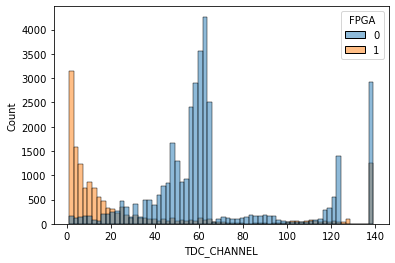

In [50]:
sns.histplot(data, x = data['TDC_CHANNEL'], hue='FPGA')

#### 8)

In [82]:
data_group = data.groupby(['FPGA', 'TDC_CHANNEL'], as_index=False).count()
print(data_group.head(), '\n')

data_sorted = data_group.sort_values(by = 'HEAD', ascending=False)
print(data_sorted.head(), '\n')

noisy_0 = data_sorted[data_sorted['FPGA'] == 0].iloc[:3]
noisy_1 = data_sorted[data_sorted['FPGA'] == 1].iloc[:3]

print('the most noisy channels for FPGA 0 are', noisy_0['TDC_CHANNEL'].values)
print('the most noisy channels for FPGA 1 are', noisy_1['TDC_CHANNEL'].values)

   FPGA  TDC_CHANNEL  HEAD  ORBIT_CNT  BX_COUNTER  TDC_MEAS
0     0            1    40         40          40        40
1     0            2    56         56          56        56
2     0            3    57         57          57        57
3     0            4    72         72          72        72
4     0            5    59         59          59        59 

     FPGA  TDC_CHANNEL  HEAD  ORBIT_CNT  BX_COUNTER  TDC_MEAS
117     0          139  2915       2915        2915      2915
56      0           64  2463       2463        2463      2463
55      0           63  2438       2438        2438      2438
53      0           61  1845       1845        1845      1845
54      0           62  1826       1826        1826      1826 

the most noisy channels for FPGA 0 are [139  64  63]
the most noisy channels for FPGA 1 are [139   2   1]


#### 9)

In [90]:
unique_orbit = data['ORBIT_CNT'].nunique()
print(f'the total number of unique orbits is {unique_orbit}')

unique_orbit_139 = data[data['TDC_CHANNEL'] == 139]['ORBIT_CNT'].nunique()
print(f'the number of unique orbits with at least one measurement from TDC_CHANNEL 193 is: {unique_orbit_139}')

the total number of unique orbits is 498
the number of unique orbits with at least one measurement from TDC_CHANNEL 193 is: 498
